In [65]:
import pandas as pd

In [66]:
df = pd.read_csv("results.csv")
df

,n_nodes,n_edges,avg_degree,avg_clustering,n_sources,n_infected_nodes,n_iterations,percentage_infected,beta,threshold_infected,graph_type,neighbours,prob_reconnect
0,131,131,1.000000,0.000000,4,40,27,0.037108,0.128382,0.286480,watts_strogatz,2,0.233689
1,708,1416,2.000000,0.261384,34,440,7,0.049107,0.284080,0.498066,watts_strogatz,5,0.220991
2,332,332,1.000000,0.000000,8,151,26,0.026584,0.448967,0.440083,watts_strogatz,2,0.491708
3,284,283,0.996479,0.000000,6,97,14,0.023474,0.195024,0.287531,barabasi_albert,1,0.200873
4,154,154,1.000000,0.015152,2,88,51,0.013261,0.212788,0.562779,watts_strogatz,2,0.353269
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9492,436632,46.000000,0.166991,178,9492,3,0.018821,0.377587,0.333076,watts_strogatz,92,0.398050
9996,9602,411037,42.807436,0.032103,326,9602,4,0.033967,0.237037,0.718213,barabasi_albert,43,0.321127
9997,9967,476112,47.768837,0.033437,138,9967,4,0.013872,0.363369,0.789226,barabasi_albert,48,0.421031
9998,9819,410634,41.820348,0.030987,369,9819,4,0.037611,0.188437,0.460572,barabasi_albert,42,0.019220


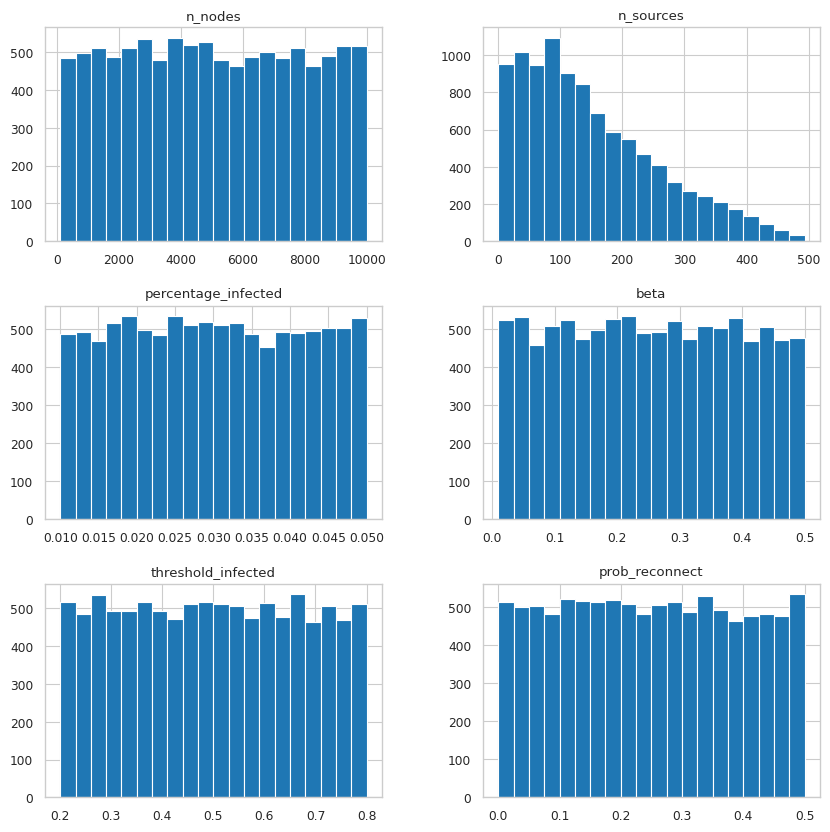

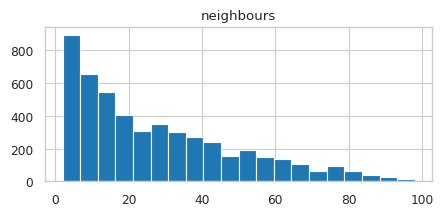

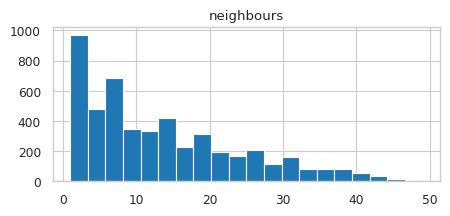

watts_strogatz     5016
barabasi_albert    4984
Name: graph_type, dtype: int64

In [67]:
# check the distributions of the parameters
import matplotlib.pyplot as plt

df[["n_nodes", "n_sources", "percentage_infected", "beta", "threshold_infected", "prob_reconnect"]].hist(figsize=(10, 10), bins=20)
plt.show()

df.loc[df["graph_type"] == "watts_strogatz",["graph_type", "neighbours"]].hist(figsize=(5, 2), bins=20)
plt.show()

df.loc[df["graph_type"] == "barabasi_albert",["graph_type", "neighbours"]].hist(figsize=(5, 2), bins=20)
plt.show()

# count the number of graphs of each type
df["graph_type"].value_counts()

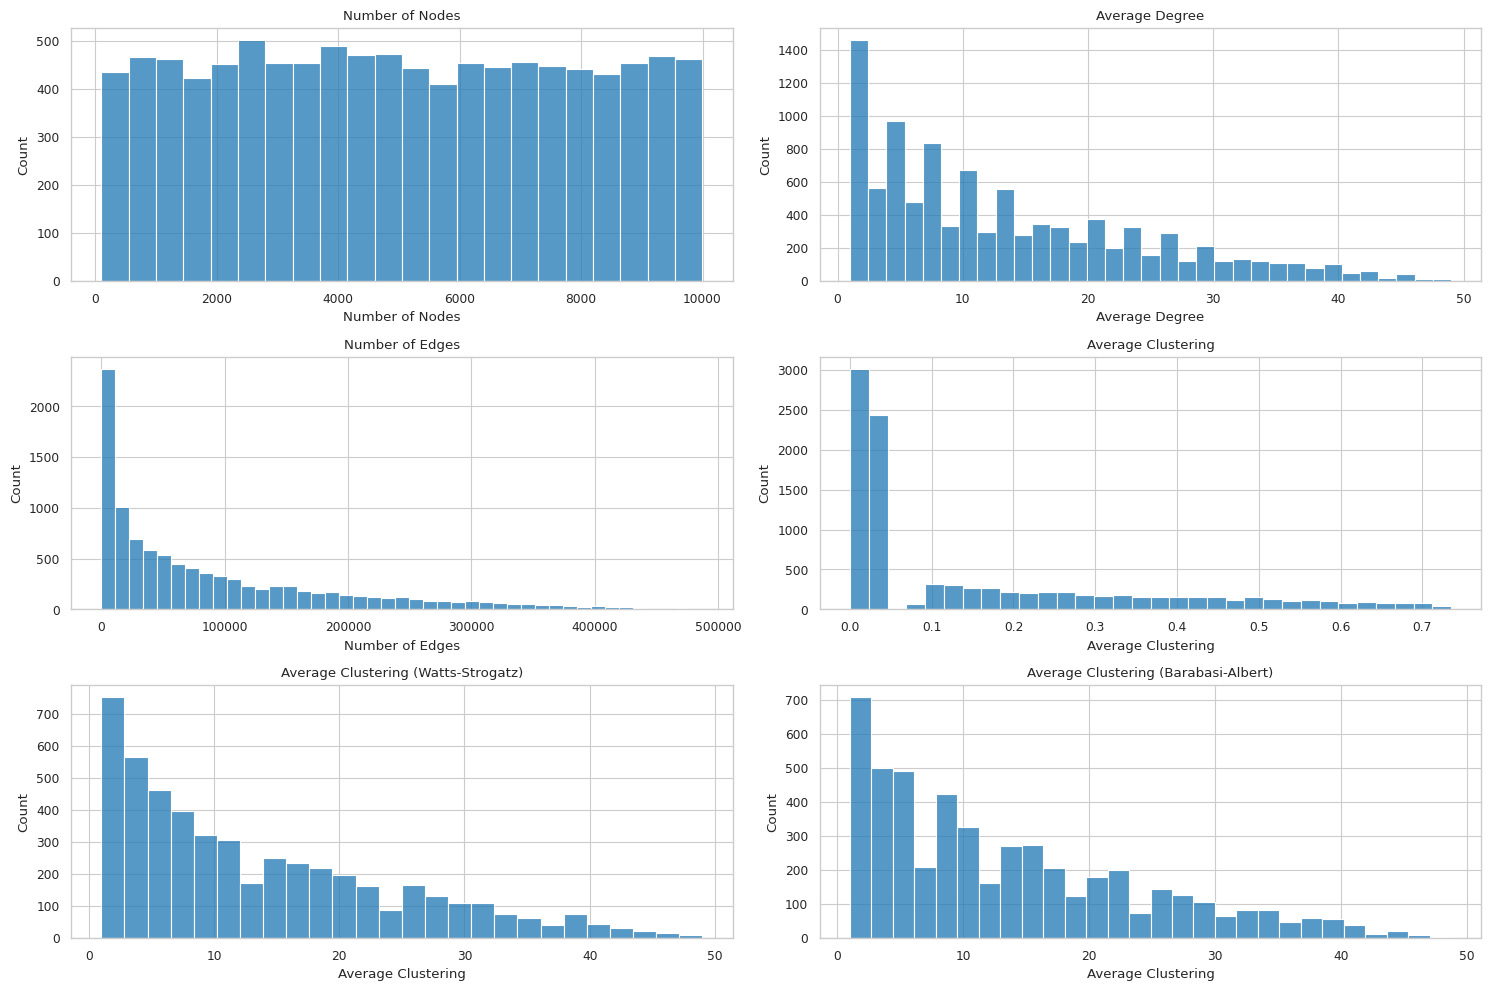

In [68]:
# visualize the graph metrics
# create a histogram for each metric
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("paper")

fig, ax = plt.subplots(3, 2, figsize=(15, 10))

sns.histplot(data=df, x="n_nodes", ax=ax[0, 0])
sns.histplot(data=df, x="n_edges", ax=ax[1, 0])
sns.histplot(data=df, x="avg_degree", ax=ax[0, 1])
sns.histplot(data=df, x="avg_clustering", ax=ax[1, 1])
sns.histplot(data=df[df["graph_type"]=="watts_strogatz"], x="avg_degree", ax=ax[2, 0])
sns.histplot(data=df[df["graph_type"]=="barabasi_albert"], x="avg_degree", ax=ax[2, 1])

# add axis labels
ax[0, 0].set_xlabel("Number of Nodes")
ax[1, 0].set_xlabel("Number of Edges")
ax[0, 1].set_xlabel("Average Degree")
ax[1, 1].set_xlabel("Average Clustering")
ax[2, 0].set_xlabel("Average Clustering")
ax[2, 1].set_xlabel("Average Clustering")

# add title
ax[0, 0].set_title("Number of Nodes")
ax[1, 0].set_title("Number of Edges")
ax[0, 1].set_title("Average Degree")
ax[1, 1].set_title("Average Clustering")
ax[2, 0].set_title("Average Clustering (Watts-Strogatz)")
ax[2, 1].set_title("Average Clustering (Barabasi-Albert)")

plt.tight_layout()
plt.show()

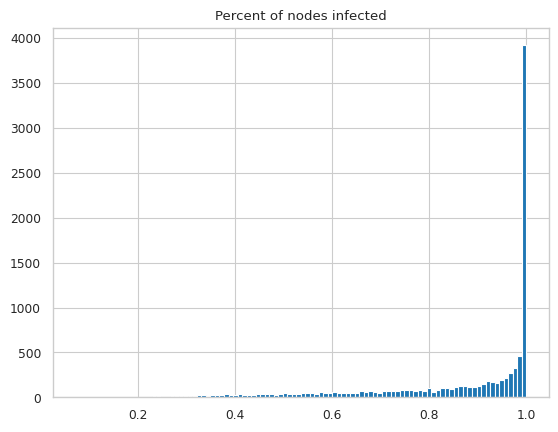

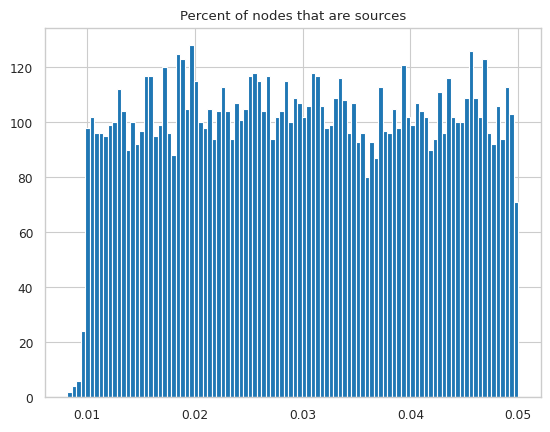

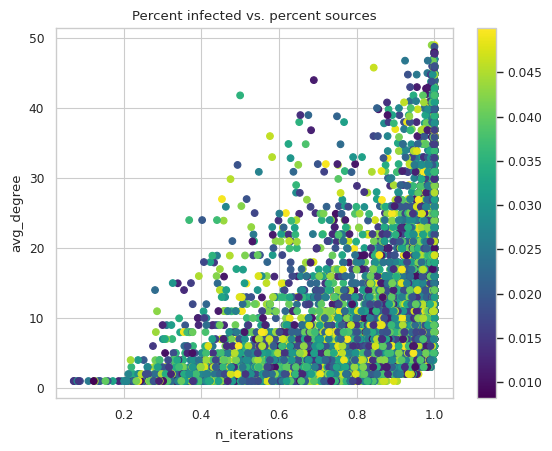

In [78]:
df["percent_infected"] = df["n_infected_nodes"] / df["n_nodes"]
df["percent_sources"] = df["n_sources"] / df["n_nodes"]

# plot the results
import matplotlib.pyplot as plt

plt.hist(df["percent_infected"], bins=100)
plt.title("Percent of nodes infected")
plt.show()

plt.hist(df["percent_sources"], bins=100)
plt.title("Percent of nodes that are sources")
plt.show()

df["graph_type_numeric"] = df["graph_type"].map({"watts_strogatz": 0, "barabasi_albert": 1}) 

# plot a scatter plot of percent infected vs. percent sources colored by number of iterations
plt.scatter(
    df["percent_infected"],
    df["avg_degree"],
    c=df["percent_sources"],
    cmap="viridis",
)
plt.colorbar()
plt.title("Percent infected vs. percent sources")
plt.xlabel("percent_infected")
plt.ylabel("avg_degree")
plt.show()

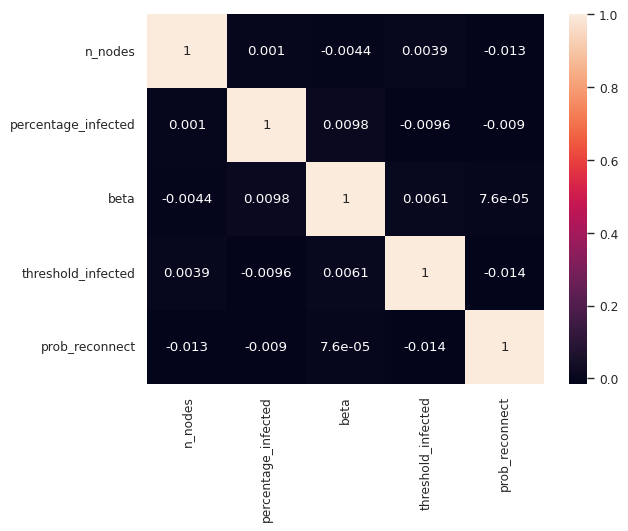

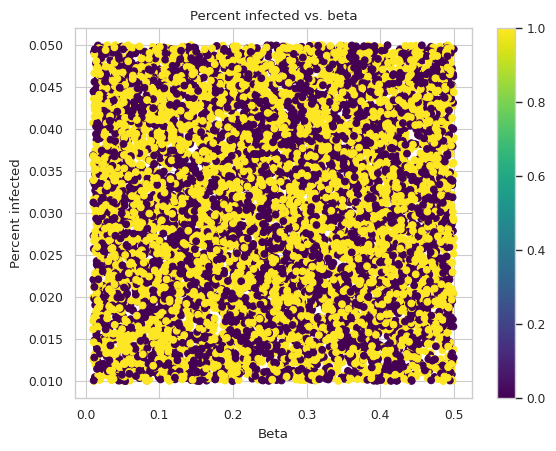

In [70]:
# check for correlation between parameters
import seaborn as sns

sns.heatmap(df[["n_nodes", "percentage_infected", "beta", "threshold_infected", "prob_reconnect"]].corr(), annot=True)
plt.show()

# create a scatter plot of percent infected vs. beta
plt.scatter(
    df["beta"],
    df["percentage_infected"],
    c=df["graph_type_numeric"],
    cmap="viridis",
)
plt.colorbar()
plt.title("Percent infected vs. beta")
plt.xlabel("Beta")
plt.ylabel("Percent infected")
plt.show()

In [6]:
# iterate over every data object in the data/training/synthetic/raw folder
import os
import pandas as pd
import torch
import numpy as np
from pathlib import Path
from torch_geometric.utils.convert import to_networkx
import networkx as nx

data_dir = Path("data/training/synthetic/raw")
data_files = os.listdir(data_dir)

# create a list of dictionaries to store the data
metrics = []

for data_file in data_files:
    data = torch.load(data_dir/data_file)
    graph = to_networkx(
            data, to_undirected=False, remove_self_loops=True
        ).to_undirected()
    # calculate the average degree centrality
    avg_degree_centrality = np.mean(list(nx.degree_centrality(graph).values()))
    print (avg_degree_centrality)


0.03192409762103818
0.005623828369089773
0.03373493975903615
0.03130898428200768
0.006207769703855726
0.04716981132075471
0.0380502545896776
0.029899941706628408
0.007782101167315175
0.033464317403980225
0.04517826739224421
0.033513097072419104
0.013865404125803178
0.040421480020464126
0.04153455770918083
0.015166009049285507
0.03068969973721621
0.014336917562724013
0.0067264063902124594
0.02639421030225628
0.0355387450726283
0.04571871367686944
0.004992290656690828
0.04740786052913289
0.033023735810113516
0.0057574667146455556
0.030499675535366644
0.021234106939749198
0.011015237745548008
0.027872972355494633
0.031999999999999994
0.04699362259844805
0.01905582484095082
0.0010027073097362879
0.013197835554968984
0.022328665724580497
0.016259290064661536
0.03231690064940314
0.024081970064113046
0.02439691252865586
0.033062330623306234
0.0037942664418212473
0.014754515390485879
0.0029154461603020025
0.009191483273243936
0.0390970397936671
0.020864946889226105
0.010704627737641512
0.04781

OSError: [Errno 22] Invalid argument